# 10. Feature generation (R)

In [1]:
library(tidyverse)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
sample_consolidated_file <- "../preprocessed_data/sample_consolidated_2019-08-26.feather"

## Read data

In [3]:
sample <- feather::read_feather(sample_consolidated_file)
glimpse(sample)

Observations: 1,068
Variables: 23
$ YEAR                  <dbl> 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008,…
$ COMMODITY             <chr> "crude", "crude", "crude", "crude", "crude", "c…
$ OPERATOR_ID           <chr> "Kinder Morgan (Group)", "BP (Group)", "Enbridg…
$ NAME                  <chr> "Kinder Morgan (Group)", "BP (Group)", "Enbridg…
$ MILES                 <dbl> 190.000, 441.000, 1497.000, 385.080, 1951.000, …
$ AGE_UNKNOWN_MILES     <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, NA, NA, NA, NA…
$ MILES_PRE_1940        <dbl> 0.000, 0.000, 0.000, 270.033, 96.000, 0.500, 0.…
$ MILES_1940            <dbl> 0.000, 280.000, 444.000, 166.000, 686.000, 0.00…
$ MILES_1950            <dbl> 243.000, 106.000, 1.000, 325.000, 882.000, 0.00…
$ MILES_1960            <dbl> 0.000, 27.000, 3.000, 50.000, 432.000, 0.000, 1…
$ MILES_1970            <dbl> 0.000, 7.000, 7.000, 29.000, 434.000, 57.500, 2…
$ MILES_1980            <dbl> 0.000, 5.000, 2.000, 72.981, 276.000, 0.000, 0.…
$ MILES_1990      

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 233 rows containing non-finite values (stat_bin).”

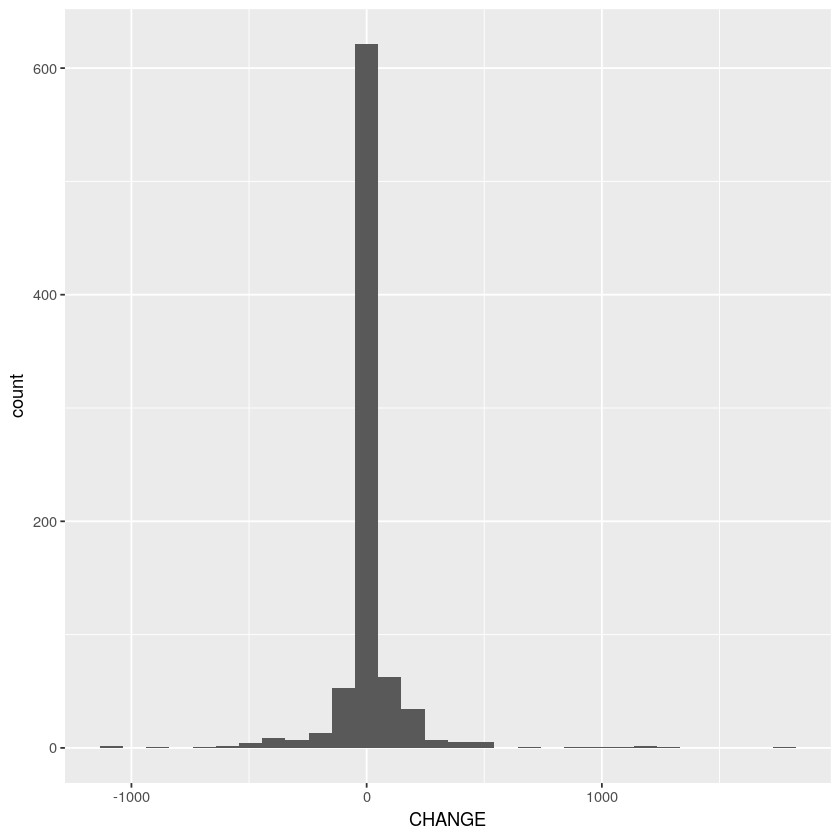

In [4]:
sample %>%
    ggplot(aes(x=CHANGE)) +
        geom_histogram()

In [5]:
nrow(sample)

[1] 1068

In [6]:
# sample <- subset(sample, abs(CHANGE) < 250)

In [7]:
nrow(sample)

[1] 1068

## 10.1 Three year moving average

Change

In [8]:
sample <- sample %>%
    group_by(OPERATOR_ID, COMMODITY) %>%
    arrange(desc(YEAR)) %>%
    mutate(change_1 = lead(CHANGE, 1), 
           change_2 = lead(CHANGE, 2), 
           change_3 = MILES - lead(MILES, 3)) %>%
    mutate(mean_change_3 = (change_3 / 3)) %>%
    mutate(sd_change_3 = sqrt((CHANGE - mean_change_3)^2 + (change_1 - mean_change_3)^2 + (change_2 - mean_change_3)^2 / 3))

Incidents

In [9]:
sample <- sample %>%
    group_by(OPERATOR_ID, COMMODITY) %>%
    arrange(desc(YEAR)) %>%
    mutate(miles_avg_3 = (MILES + lead(MILES, 1) + lead(MILES, 2)) / 3, 
           miles_1950_3 = (MILES_1950 + lead(MILES_1950, 1) + lead(MILES_1950, 2)) / 3,
           sign_inc_3 =  (SIGNIFICANT_INCIDENTS + lag(SIGNIFICANT_INCIDENTS, 1) + lag(SIGNIFICANT_INCIDENTS, 2)) / 3)

Incidents per mile

In [10]:
sample$inc_per_mile_3 <- sample$sign_inc_3 / sample$miles_avg_3

Percent of pipelines for each decade.

In [11]:
sample <- sample %>%
    mutate(age_miles = MILES_PRE_1940 + MILES_1940 + MILES_1950 + MILES_1960 + MILES_1970 + MILES_1980 +
                       MILES_1990 + MILES_2000 + MILES_2010)

In [12]:
sample <- sample %>%
    mutate(perc_pre_1940 = MILES_PRE_1940 / age_miles, 
           perc_1940 = MILES_1940 / age_miles,
           perc_1950 = MILES_1950 / age_miles,
           perc_1960 = MILES_1960 / age_miles,
           perc_1970 = MILES_1970 / age_miles,
           perc_1980 = MILES_1980 / age_miles,
           perc_1990 = MILES_1990 / age_miles,
           perc_2000 = MILES_2000 / age_miles, 
           perc_2010 = MILES_2010 / age_miles)

In [13]:
sample <- sample %>%
    group_by(OPERATOR_ID, COMMODITY) %>%
    arrange(desc(YEAR)) %>%
    mutate(avg_pre_1940 = (perc_pre_1940 + lag(perc_pre_1940) + lag(perc_pre_1940, 2)) /3, 
           avg_1940 = (perc_1940 + lag(perc_1940) + lag(perc_1940, 2)) / 3,
           avg_1950 = (perc_1950 + lag(perc_1950) + lag(perc_1950, 2)) / 3,
           avg_1960 = (perc_1960 + lag(perc_1960) + lag(perc_1960, 2)) / 3,
           avg_1970 = (perc_1970 + lag(perc_1970) + lag(perc_1970, 2)) / 3,
           avg_1980 = (perc_1980 + lag(perc_1980) + lag(perc_1980, 2)) / 3,
           avg_1990 = (perc_1990 + lag(perc_1990) + lag(perc_1990, 2)) / 3,
           avg_2000 = (perc_2000 + lag(perc_2000) + lag(perc_2000, 2)) / 3,
           avg_2010 = (perc_2010 + lag(perc_2010) + lag(perc_2010, 2)) / 3)

## 10.2 Incidents per mile

In [14]:
sample$INCIDENTS_MILE <- (sample$INCIDENTS / sample$MILES)
sample$SIGN_INC_MILE <- (sample$SIGNIFICANT_INCIDENTS / sample$MILES)

In [15]:
nrow(sample[!is.na(sample$sd_change_3), ])

[1] 534

## 10.3 Data types

In [16]:
sample$COMMODITY <- as.factor(sample$COMMODITY)
sample$OPERATOR_ID <- as.factor(sample$OPERATOR_ID)

## 10.4 past M&As

In [17]:
sample <- sample %>%
    group_by(OPERATOR_ID, COMMODITY) %>%
    arrange(desc(YEAR)) %>%
    mutate(M_A_3 = max(M_A, lead(M_A), lead(M_A, 2), na.rm=TRUE))
glimpse(sample)

Observations: 1,068
Variables: 54
Groups: OPERATOR_ID, COMMODITY [228]
$ YEAR                  <dbl> 2018, 2018, 2018, 2018, 2018, 2018, 2018, 2018,…
$ COMMODITY             <fct> crude, hvl, non-hvl, crude, hvl, non-hvl, crude…
$ OPERATOR_ID           <fct> Enbridge (Group), Enbridge (Group), Enbridge (G…
$ NAME                  <chr> "Enbridge (Group)", "Enbridge (Group)", "Enbrid…
$ MILES                 <dbl> 3201.980, 163.740, 854.440, 263.500, 180.700, 3…
$ AGE_UNKNOWN_MILES     <dbl> 0.000, 0.000, 0.000, 5.500, 0.000, 27.400, 429.…
$ MILES_PRE_1940        <dbl> 0.00, 0.00, 0.00, 0.00, 0.00, 84.28, 269.07, 4.…
$ MILES_1940            <dbl> 9.000, 0.000, 0.000, 0.300, 0.000, 182.300, 500…
$ MILES_1950            <dbl> 247.620, 188.820, 133.810, 157.300, 6.900, 1157…
$ MILES_1960            <dbl> 19.750, 0.000, 273.300, 57.000, 32.700, 309.780…
$ MILES_1970            <dbl> 7.390, 0.000, 85.500, 40.100, 81.000, 571.280, …
$ MILES_1980            <dbl> 0.000, 0.000, 1.800, 75.900, 6

## 10.5 Log transform etc.

In [18]:
sample$LOG_INCIDENTS_MILE <- log(sample$INCIDENTS_MILE)
sample$LOG_SIGN_INC_MILE <- log(sample$SIGN_INC_MILE)
sample$log_sd_change <- log(sample$sd_change_3)
sample$sd_change_sq <- (sample$sd_change_3)^2
sample$sd_change_pw_3 <- (sample$sd_change_3)^3
sample$one_over_sd_change <- (1 / sample$sd_change_3)

## 10.6 Interaction effects

In [19]:
sample$miles_x_change <- sample$MILES * sample$sd_change_3

## 10.7 Subsamples

In [20]:
sample_crude <- sample[(sample$COMMODITY == "crude"), ]

## 10.7 Save

In [21]:
feather::write_feather(sample, paste0("../preprocessed_data/sample_features_", Sys.Date(), ".feather"))
haven::write_dta(sample, paste0("../stata_data/sample_features_", Sys.Date(), ".dta"))
feather::write_feather(sample_crude, paste0("../preprocessed_data/sample_features_crude_", Sys.Date(), ".feather"))
haven::write_dta(sample_crude, paste0("../stata_data/sample_features_crude_", Sys.Date(), ".dta"))